### 1.Import Required Libraries

In [4]:
import re #Text preprocessing and pattern matching
import string 
import math #Mathematical operations for probability calculations
from collections import Counter, OrderedDict #Efficient counting and ordered dictionaries
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt


### 2: Text Preprocessing Function

In [5]:
#An n-gram is a contiguous sequence of n items (usually words or characters) from a given text.
#Default false if true(unigram)
def preprocess_text(text, use_ngrams=False, n_gram_range=(1, 1)):

    if not isinstance(text, str):#checks if text is string if not null
        text = ""
        
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    text=re.sub(r'/s+','',text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    if use_ngrams:
        all_ngrams = []
        for n in range(n_gram_range[0], n_gram_range[1] + 1):
            if n == 1:
                all_ngrams.extend(filtered_tokens)
            elif n > 1:
                for i in range(len(filtered_tokens) - n + 1):#if n=2 then i=5
                    all_ngrams.append("_".join(filtered_tokens[i:i+n]))
        return all_ngrams
    return filtered_tokens

# Test the preprocessing function
sample_text = "Hello World! This is a sample text with numbers 123 and punctuation."
print("Original:", sample_text)
print("Preprocessed:", preprocess_text(sample_text))
print("With bigrams:", preprocess_text(sample_text, use_ngrams=True, n_gram_range=(1, 2)))

Original: Hello World! This is a sample text with numbers 123 and punctuation.
Preprocessed: ['hello', 'world', 'sample', 'text', 'numbers', 'punctuation']
With bigrams: ['hello', 'world', 'sample', 'text', 'numbers', 'punctuation', 'hello_world', 'world_sample', 'sample_text', 'text_numbers', 'numbers_punctuation']


### 3: TF-IDF Calculation Functions

In [6]:
def calculate_tf(doc_tokens):

    tf = Counter(doc_tokens)
    total_words = sum(tf.values())
    if total_words == 0:
        return {}
    return {word: count / total_words for word, count in tf.items()}



def calculate_idf(all_processed_docs_tokens, vocabulary):
    df = Counter() # Document Frequency
    total_docs = len(all_processed_docs_tokens)

    for doc_tokens in all_processed_docs_tokens:
        for word in set(doc_tokens):
            if word in vocabulary:
                df[word] += 1

    idf = {}
    for word_idx, word in enumerate(vocabulary.keys()):
        idf[word] = math.log10(total_docs / (df[word] + 1)) + 1
    return idf


sample_tokens = ['machine', 'learning', 'algorithm', 'machine', 'learning']
tf_scores = calculate_tf(sample_tokens)
print("TF Scores:", tf_scores)

TF Scores: {'machine': 0.4, 'learning': 0.4, 'algorithm': 0.2}


###  4: Vocabulary Building

In [1]:
def build_vocabulary(all_processed_docs_tokens, max_features=5000, min_doc_freq=2, max_doc_freq_ratio=0.85):
    """
    Builds a vocabulary of most frequent words, filtering by document frequency.
    Returns an OrderedDict mapping word to index.
    """
    word_counts = Counter()
    doc_word_presence = Counter()
   

    for doc_tokens in all_processed_docs_tokens:
        word_counts.update(doc_tokens)
        for word in set(doc_tokens):
            doc_word_presence[word] += 1

    filtered_vocab = OrderedDict()
    sorted_words = sorted(word_counts.items(), key=lambda item: (-item[1], item[0]))
    total_docs = len(all_processed_docs_tokens)

    #Removing irrelevant or noisy words (too rare)

    for word, count in sorted_words:
        if doc_word_presence[word] >= min_doc_freq and \
           doc_word_presence[word] <= total_docs * max_doc_freq_ratio:
            filtered_vocab[word] = len(filtered_vocab)
            if len(filtered_vocab) >= max_features:
                break
    return filtered_vocab


def document_to_tfidf_vector(doc_tokens, vocabulary, idf_scores):
    """
    Converts a list of tokens into a TF-IDF vector.
    """
    vector = [0.0] * len(vocabulary)
    tf_scores = calculate_tf(doc_tokens)

    for word, tf_val in tf_scores.items():
        if word in vocabulary:
            word_idx = vocabulary[word]
            idf_val = idf_scores.get(word, 0)
            vector[word_idx] = tf_val * idf_val
    return np.array(vector, dtype=float)


### 5.Naive Bayes Classifier

In [8]:

# X_train_tokens: list of lists of preprocessed tokens (e.g., [['word1', 'word2'], ...])
# y_train_labels: list of corresponding class labels (e.g., ['culture', 'hike', ...])
def train_naive_bayes_model(X_train_tokens, y_train_labels, vocabulary, smoothing_alpha=1.0):
    
    all_classes = sorted(list(set(y_train_labels)))
    total_documents = len(y_train_labels)
    
    class_priors = {c: 0 for c in all_classes}
    class_word_counts = {c: Counter() for c in all_classes}
    total_words_in_class = {c: 0 for c in all_classes}

    # Calculate class priors and word counts per class
    for i, doc_tokens in enumerate(X_train_tokens):
        label = y_train_labels[i]
        class_priors[label] += 1
        class_word_counts[label].update(doc_tokens)

    # Convert class priors to probabilities
    for c in class_priors:
        class_priors[c] = class_priors[c] / total_documents
            
    # Calculate P(word | class) with Laplace smoothing
    vocab_size = len(vocabulary) # Size of the global vocabulary
    word_probabilities = {c: {} for c in all_classes}

    for c in all_classes:
        # Total words in this class, including smoothing for unseen words
        total_words_in_class[c] = sum(class_word_counts[c].values()) + vocab_size * smoothing_alpha

        for word_token in vocabulary: # Iterate over the full vocabulary
            count = class_word_counts[c].get(word_token, 0);
            # P(word | class) = (Count(word in class) + alpha) / (Total words in class + alpha * Vocab Size)
            word_probabilities[c][word_token] = (count + smoothing_alpha) / total_words_in_class[c]
            
    return class_priors, word_probabilities, total_words_in_class


def predict_single_blog(doc_tokens, vocabulary, class_priors, word_probabilities, total_words_in_class, smoothing_alpha=1.0):
    # """
    # Predicts the class label for a single document.
    # doc_tokens: list of preprocessed tokens for the document.
    # vocabulary: The global vocabulary (OrderedDict).
    # class_priors: Dictionary of class prior probabilities.
    # word_probabilities: Dictionary of word probabilities P(word | class).
    # total_words_in_class: Dictionary of total word counts per class (for smoothing).
    # smoothing_alpha: Laplace smoothing parameter.
    # Returns: The predicted class label.
    # """
    best_class = None
    max_log_posterior = -float('inf')

    for c, prior_prob in class_priors.items():
        # Use log probabilities to avoid underflow
        log_posterior = math.log(prior_prob)
        
        for word_token in doc_tokens:
            # Only consider words present in the training vocabulary
            if word_token in vocabulary:
                # Get P(word | class) for this word in this class
                word_prob = word_probabilities[c].get(word_token, smoothing_alpha / total_words_in_class[c])
                log_posterior += math.log(word_prob)

        if log_posterior > max_log_posterior:
            max_log_posterior = log_posterior
            best_class = c
    return best_class

 ### 6: Evaluation Metrics

In [9]:
def save_model_params(vocabulary, idf_scores, class_priors, word_probabilities, total_words_in_class, filename="naive_bayes_model_params.pkl"):
    """Save the trained model parameters to a file."""
    with open(filename, "wb") as f:
        pickle.dump({
            "vocabulary": vocabulary,
            "idf_scores": idf_scores,
            "class_priors": class_priors,
            "word_probabilities": word_probabilities,
            "total_words_in_class": total_words_in_class
        }, f)
    print(f"Model parameters saved to {filename}")

def load_model_params(filename="naive_bayes_model_params.pkl"):
    """Load the trained model parameters from a file."""
    with open(filename, "rb") as f:
        data = pickle.load(f)
    print(f"Model parameters loaded from {filename}")
    return (
        data["vocabulary"],
        data["idf_scores"],
        data["class_priors"],
        data["word_probabilities"],
        data["total_words_in_class"]
    )



def calculate_accuracy(y_true, y_pred):
    """Calculates accuracy score."""
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return correct_predictions / len(y_true) if len(y_true) > 0 else 0.0

def calculate_precision_recall_f1(y_true, y_pred, labels):
    """Calculates precision, recall, and F1-score for each label and macro average."""
    metrics = {}
    true_positives = Counter()
    false_positives = Counter()
    false_negatives = Counter()

    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            true_positives[true_label] += 1
        else:
            false_positives[pred_label] += 1
            false_negatives[true_label] += 1

    for label in labels:
        tp = true_positives[label]
        fp = false_positives[label]
        fn = false_negatives[label]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        metrics[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': y_true.count(label) # Number of occurrences of the label in y_true
        }

    # Macro average (simple average of per-class metrics)
    total_precision = sum(metrics[label]['precision'] for label in labels)
    total_recall = sum(metrics[label]['recall'] for label in labels)
    total_f1 = sum(metrics[label]['f1-score'] for label in labels)
    
    num_labels = len(labels)
    if num_labels > 0:
        metrics['macro avg'] = {
            'precision': total_precision / num_labels,
            'recall': total_recall / num_labels,
            'f1-score': total_f1 / num_labels,
            'support': len(y_true) # Total samples in the dataset for macro avg support
        }
    else:
        metrics['macro avg'] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}

    return metrics

### 7. Main Supervised Learning PipeLine

In [10]:
def run_supervised_categorization(df, text_column='content', category_column='category',
                                  use_ngrams=True, n_gram_range=(1, 2),
                                  test_size=0.2, random_state=42):
    
    print("Step 1: Preparing data for supervised learning...")
    # Shuffle the DataFrame and split into training and testing sets
    df_shuffled = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    split_idx = int(len(df_shuffled) * (1 - test_size))
    
    train_df = df_shuffled.iloc[:split_idx]
    test_df = df_shuffled.iloc[split_idx:]

    X_train_raw = train_df[text_column].tolist()
    y_train = train_df[category_column].tolist()
    X_test_raw = test_df[text_column].tolist()
    y_test = test_df[category_column].tolist()

    print(f"Training set size: {len(X_train_raw)} documents")
    print(f"Testing set size: {len(X_test_raw)} documents")


    print("Step 2: Preprocessing training data and building vocabulary...")
    processed_train_tokens = [preprocess_text(text, use_ngrams=use_ngrams, n_gram_range=n_gram_range) for text in X_train_raw]
    vocabulary = build_vocabulary(processed_train_tokens, max_features=5000, min_doc_freq=2, max_doc_freq_ratio=0.85)
    
    idf_scores = calculate_idf(processed_train_tokens, vocabulary)
    print(f"Vocabulary size: {len(vocabulary)}")

    # --- Visualization: Top N words in Vocabulary ---
    top_words = list(vocabulary.keys())[:20]
    print("\nTop 20 words in Vocabulary (based on frequency):")
    word_freq = Counter(token for doc in processed_train_tokens for token in doc if token in vocabulary)
    common_words_in_vocab = word_freq.most_common(20)

    if common_words_in_vocab:
        plt.figure(figsize=(10, 6))
        words = [word for word, count in common_words_in_vocab]
        counts = [count for word, count in common_words_in_vocab]
        plt.barh(words[::-1], counts[::-1]) # Reverse for highest at top
        plt.title('Top 20 Most Frequent Words in Training Data (after preprocessing & vocabulary)')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.tight_layout()
        plt.show()
    else:
        print("No words to display for vocabulary visualization.")
  

    processed_test_tokens = [preprocess_text(text, use_ngrams=use_ngrams, n_gram_range=n_gram_range) for text in X_test_raw]

    print("Step 3: Training Naive Bayes Model (Functional)...")
    class_priors, word_probabilities, total_words_in_class = train_naive_bayes_model(
        processed_train_tokens, y_train, vocabulary
    )
    print("Model trained.")

    print("Step 4: Making predictions on the test set...")
    predictions = []
    for doc_tokens in processed_test_tokens:
        predicted_label = predict_single_blog(
            doc_tokens, vocabulary, class_priors, word_probabilities, total_words_in_class
        )
        predictions.append(predicted_label)
    print("Predictions made.")

    print("\n" + "="*80)
    print("STEP 5: EVALUATION OF SUPERVISED MODEL")
    print("="*80)

    accuracy = calculate_accuracy(y_test, predictions)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    unique_labels = sorted(list(set(y_test + predictions)))
    metrics = calculate_precision_recall_f1(y_test, predictions, unique_labels)

    print("\nClassification Report:")
    print(f"{'Category':<25}{'Precision':>10}{'Recall':>10}{'F1-Score':>10}{'Support':>10}")
    print("-" * 65)
    
    for label in unique_labels:
        m = metrics.get(label, {'precision':0, 'recall':0, 'f1-score':0, 'support':0})
        print(f"{label:<25}{m['precision']:>10.2f}{m['recall']:>10.2f}{m['f1-score']:>10.2f}{m['support']:>10}")
    
    if 'macro avg' in metrics:
        macro_m = metrics['macro avg']
        print("-" * 65)
        print(f"{'Macro Average':<25}{macro_m['precision']:>10.2f}{macro_m['recall']:>10.2f}{macro_m['f1-score']:>10.2f}{macro_m['support']:>10}")


    print("\n--- Sample Predictions ---")
    num_samples_to_show = min(10, len(test_df))
    for i in range(num_samples_to_show):
        original_title = test_df.iloc[i]['title']
        original_content = test_df.iloc[i]['content']
        true_cat = y_test[i]
        predicted_cat = predictions[i]
        # Fix: Convert title to string and handle NaN
        title_str = str(original_title) if pd.notnull(original_title) else "(No Title)"
        print(f"Test Blog {i+1}: '{title_str[:60]}...' ")
        print(f"  True Category: '{true_cat}'")
        print(f"  Predicted Category: '{predicted_cat}'")
        if true_cat != predicted_cat:
            print("  (MISCLASSIFIED)")
        print("-" * 75)

    save_model_params(vocabulary, idf_scores, class_priors, word_probabilities, total_words_in_class)

    return predictions, y_test, (vocabulary, idf_scores, class_priors, word_probabilities, total_words_in_class)

### 8. Excecution Block


Successfully loaded 5636 blogs from dataset.csv

First 5 rows of the dataset:
    id                                          title  \
0  370              Himalayan Brown Bear Conservation   
1  371    Clouded Leopard Research in Nepal's Forests   
2  372        Wild Water Buffalo Conservation Efforts   
3  373      Fishing Cat Conservation in Wetland Areas   
4  374  Gangetic Dolphin Conservation in Nepal Rivers   

                                             content               category  
0  Himalayan brown bear conservation in Nepal's h...  wildlife/nationalpark  
1  Clouded leopard research in Nepal's forest pro...  wildlife/nationalpark  
2  Wild water buffalo conservation in Nepal's Ter...  wildlife/nationalpark  
3  Fishing cat conservation in Nepal's wetland pr...  wildlife/nationalpark  
4  Gangetic dolphin conservation in Nepal's river...  wildlife/nationalpark  


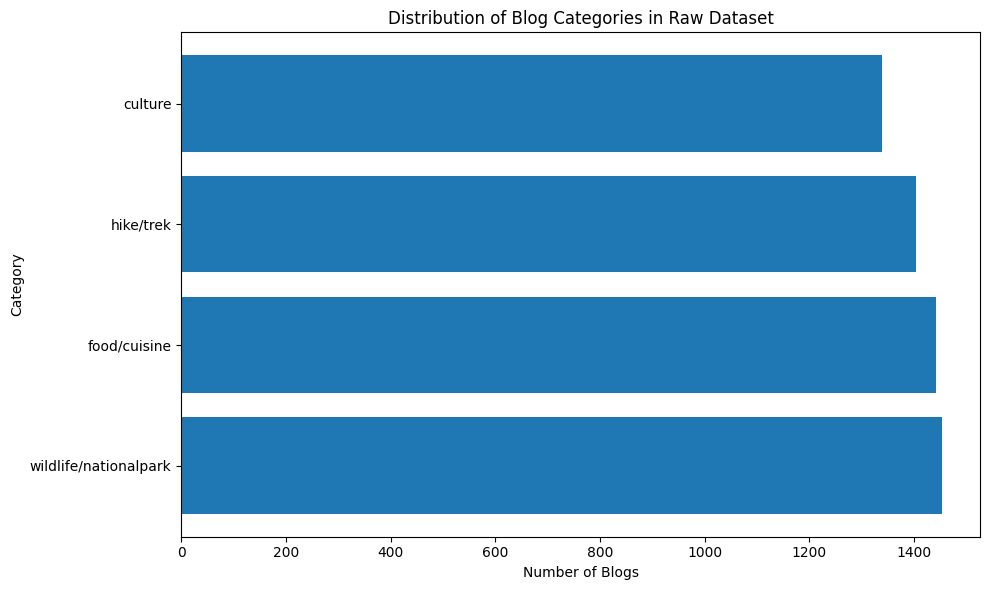

Step 1: Preparing data for supervised learning...
Training set size: 4508 documents
Testing set size: 1128 documents
Step 2: Preprocessing training data and building vocabulary...
Vocabulary size: 5000

Top 20 words in Vocabulary (based on frequency):


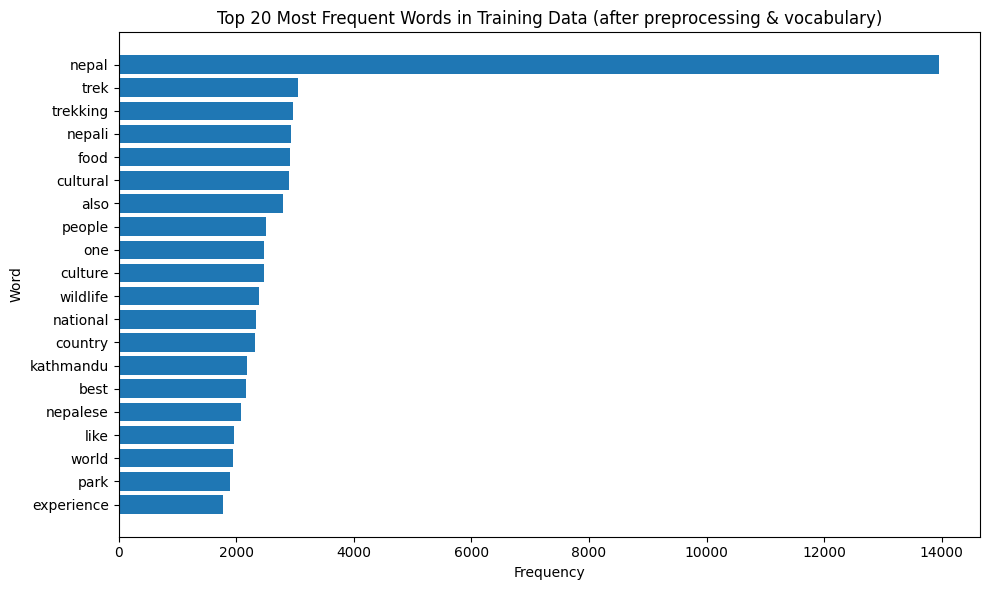

Step 3: Training Naive Bayes Model (Functional)...
Model trained.
Step 4: Making predictions on the test set...
Predictions made.

STEP 5: EVALUATION OF SUPERVISED MODEL

Overall Accuracy: 0.8023

Classification Report:
Category                  Precision    Recall  F1-Score   Support
-----------------------------------------------------------------
culture                        0.71      0.80      0.75       271
food/cuisine                   0.82      0.70      0.75       304
hike/trek                      0.82      0.92      0.87       254
wildlife/nationalpark          0.86      0.81      0.84       299
-----------------------------------------------------------------
Macro Average                  0.80      0.81      0.80      1128

--- Sample Predictions ---
Test Blog 1: 'Blog...' 
  True Category: 'food/cuisine'
  Predicted Category: 'food/cuisine'
---------------------------------------------------------------------------
Test Blog 2: 'From Dal Bhat to Momo: A Guide to Nepales

In [11]:
if __name__ == "__main__":
    csv_file_path = "dataset.csv" 

    df = None
    try:
        df = pd.read_csv(csv_file_path)
        if 'content' not in df.columns or 'category' not in df.columns or 'title' not in df.columns:
            raise ValueError(f"CSV file '{csv_file_path}' must contain 'content', 'category', and 'title' columns.")
        
        # Ensure category column is strings
        df['category'] = df['category'].astype(str)
        # Drop rows with missing or empty content
        df = df.dropna(subset=['content'])
        df = df[df['content'].str.strip().astype(bool)]

        print(f"Successfully loaded {len(df)} blogs from {csv_file_path}")

        # --- Visualization: Initial Data Overview ---
        print("\nFirst 5 rows of the dataset:")
        print(df.head())

        # Get value counts for categories
        category_counts = df['category'].value_counts()

        plt.figure(figsize=(10, 6))
        plt.barh(category_counts.index, category_counts.values)
        plt.title('Distribution of Blog Categories in Raw Dataset')
        plt.xlabel('Number of Blogs')
        plt.ylabel('Category')
        plt.tight_layout()
        plt.show()
        

    except FileNotFoundError:
        print(f"Error: CSV file '{csv_file_path}' not found. Please ensure the file is in the same directory or provide the full path.")
        exit()
    except ValueError as e:
        print(f"Error loading CSV: {e}")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV: {e}")
        exit()

    if df is None or df.empty:
        print("No data loaded or DataFrame is empty. Exiting.")
        exit()

    # --- Configuration for Supervised Learning ---
    USE_NGRAMS = True
    NGRAM_RANGE = (1, 2) # Include unigrams and bigrams
    TEST_SET_SIZE = 0.2  # 20% of data for testing, 80% for training
    RANDOM_SEED = 42     # For reproducibility of data split

    # Run the supervised categorization pipeline
    predicted_categories, true_categories, trained_params = \
        run_supervised_categorization(df, 'content', 'category', # Specify text and category columns
                                     USE_NGRAMS, NGRAM_RANGE,
                                     TEST_SET_SIZE, RANDOM_SEED)

### 9. Load Model and Predict New Blog

In [12]:

def preprocess_text(text, use_ngrams=False, n_gram_range=(1, 1)):
   
    if not isinstance(text, str):
        text = ""
        
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    if use_ngrams:
        all_ngrams = []
        for n in range(n_gram_range[0], n_gram_range[1] + 1):
            if n == 1:
                all_ngrams.extend(filtered_tokens)
            elif n > 1:
                for i in range(len(filtered_tokens) - n + 1):
                    all_ngrams.append("_".join(filtered_tokens[i:i+n]))
        return all_ngrams
    return filtered_tokens

def load_model_params(filename="naive_bayes_model_params.pkl"):
    """Load the trained model parameters from a file."""
    with open(filename, "rb") as f:
        data = pickle.load(f)
    print(f"Model parameters loaded from {filename}")
    return (
        data["vocabulary"],
        data["idf_scores"],
        data["class_priors"],
        data["word_probabilities"],
        data["total_words_in_class"]
    )


def predict_single_blog(doc_tokens, vocabulary, class_priors, word_probabilities, total_words_in_class, smoothing_alpha=1.0):
 
    best_class = None
    max_log_posterior = -float('inf')

    for c, prior_prob in class_priors.items():
        # Use log probabilities to avoid underflow
        log_posterior = math.log(prior_prob)
        
        for word_token in doc_tokens:
            # Only consider words present in the training vocabulary
            if word_token in vocabulary:
                # Get P(word | class) for this word in this class
                word_prob = word_probabilities[c].get(word_token, smoothing_alpha / total_words_in_class[c])
                log_posterior += math.log(word_prob)

        if log_posterior > max_log_posterior:
            max_log_posterior = log_posterior
            best_class = c
    return best_class

### 10. Blog 



In [13]:
                    
model_filename = "naive_bayes_model_params.pkl"

# Load the trained parameters
try:
    vocabulary_loaded, idf_scores_loaded, class_priors_loaded, word_probabilities_loaded, total_words_in_class_loaded = load_model_params(model_filename)
    print("Model parameters loaded successfully!")

    # Paste the blog to predict
    new_blog_text ="Nepali cuisine is a delightful mix of simplicity, spice, and tradition, influenced by the country’s ethnic diversity, geography, and neighboring cultures. While dal bhat tarkari (rice, lentils, and curry) is the staple meal across Nepal, each community brings its own flavors and techniques to the table."

    
    USE_NGRAMS_PREDICT = True 
    NGRAM_RANGE_PREDICT = (1, 2) 

    print(f"\nNew blog content: '{new_blog_text}'")

    # Preprocess the new blog text using the same function and settings
    processed_new_blog_tokens = preprocess_text(new_blog_text, use_ngrams=USE_NGRAMS_PREDICT, n_gram_range=NGRAM_RANGE_PREDICT)
    print(f"Processed tokens for new blog: {processed_new_blog_tokens[:10]}...") # Show first few tokens

    # Make a prediction using the loaded parameters
    prediction_for_new_blog = predict_single_blog(
        processed_new_blog_tokens,
        vocabulary_loaded,
        class_priors_loaded,
        word_probabilities_loaded,
        total_words_in_class_loaded
    )

    print(f"\nPredicted category for the new blog: {prediction_for_new_blog}")

except FileNotFoundError:
    print(f"Error: Model parameters file '{model_filename}' not found. Please ensure you have run the training pipeline and saved the model parameters.")
except Exception as e:
    print(f"An error occurred while loading or predicting: {e}")

Model parameters loaded from naive_bayes_model_params.pkl
Model parameters loaded successfully!

New blog content: 'Nepali cuisine is a delightful mix of simplicity, spice, and tradition, influenced by the country’s ethnic diversity, geography, and neighboring cultures. While dal bhat tarkari (rice, lentils, and curry) is the staple meal across Nepal, each community brings its own flavors and techniques to the table.'
Processed tokens for new blog: ['nepali', 'cuisine', 'delightful', 'mix', 'simplicity', 'spice', 'tradition', 'influenced', 'country', 'ethnic']...

Predicted category for the new blog: food/cuisine
